In [6]:
# Cell 1: Installing Necessary Libraries
get_ipython().system('pip install tensorflow')
get_ipython().system('pip install opencv-python')
get_ipython().system('pip install pillow')
get_ipython().system('pip install torch torchvision')
get_ipython().system('pip install fiftyone --user')
# Update pyarrow to meet pymilvus requirements
get_ipython().system('pip install --upgrade pyarrow')
import pyarrow
print("PyArrow Version:", pyarrow.__version__)



PyArrow Version: 16.0.0


In [1]:
# Cell 2: Setup and Dataset Loading
import fiftyone as fo
import fiftyone.zoo as foz

# Load the LFW dataset as an example
dataset = foz.load_zoo_dataset("lfw")
print(dataset)


Split 'train' already downloaded
Split 'test' already downloaded
Loading existing dataset 'lfw'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Name:        lfw
Media type:  image
Num samples: 13233
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [2]:
# cell 3
import os

# Load an existing dataset, example using 'lfw' from FiftyOne Zoo
existing_dataset = foz.load_zoo_dataset("lfw")
print("Loaded existing dataset with size:", len(existing_dataset))

# Create a new dataset
new_dataset = fo.Dataset("MND12")

# Add only 25 images from the existing dataset to the new dataset
for sample in existing_dataset.take(25):
    new_dataset.add_sample(sample)

# Specify the directory containing your new images
directory_path = "./images"  # Update this to the path of your directory

# Add images from the specified directory
image_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.jpg')]
for image_path in image_paths:
    if os.path.exists(image_path):
        sample = fo.Sample(filepath=image_path)
        new_dataset.add_sample(sample)
        print(f"Added {image_path}")

# Save changes to the new dataset
new_dataset.save()
print("All changes saved. Final dataset size:", len(new_dataset))


Split 'train' already downloaded
Split 'test' already downloaded
Loading existing dataset 'lfw'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Loaded existing dataset with size: 13233
Added ./images\alan.jpg
Added ./images\brendan.jpg
Added ./images\jeff.jpg
Added ./images\mike.jpg
Added ./images\peter.jpg
Added ./images\Ryan.jpg
Added ./images\tyler.jpg
All changes saved. Final dataset size: 32


In [4]:
# Cell 4: Define YOLO Preprocessor Class
import torch
import torchvision.transforms as transforms
from PIL import Image, ExifTags
import cv2
import numpy as np


#YOLOv8 object detection class for human faces
#Takes file path to location where model is saved as constructor argument
#Once a YoloPreprocessor object is instantiated, use the process_image function with a cv2 numpy array as img argument
#to obtain a cropped cv2 numpy array image
class YoloPreprocessor:
    def __init__(self, model_path):
        self.model = self.load_model(model_path)

    def load_model(self, model_path, model_class=None):
        model = torch.load(model_path)
        model = model['model'].float()
        model.eval()  # Set the model to evaluation mode
        return model

    def prepare_image(self, img, input_size=(640, 640), training_mode=False):
        if not isinstance(img, Image.Image):
            raise TypeError("img must be a PIL.Image.Image object")
        
        # Auto-Orient: applying orientation from image EXIF data
        exif = img.getexif()
        if exif:
            for orientation in ExifTags.TAGS.keys():
                if ExifTags.TAGS[orientation] == 'Orientation':
                    break
            orientation = exif.get(orientation, 1)
            rotations = {
                3: Image.ROTATE_180,
                6: Image.ROTATE_270,
                8: Image.ROTATE_90
            }
            if orientation in rotations:
                img = img.transpose(rotations[orientation])
        
        img = img.resize(input_size, Image.BOX)
        #img = img.convert('RGB')
        transform_list = [transforms.ToTensor()]
        if training_mode:
            transform_list.append(transforms.RandomHorizontalFlip(p=1.0))
        transform = transforms.Compose(transform_list)
        image = transform(img)
        image = image.unsqueeze(0)
        return image

    def run_inference(self, image):
        with torch.no_grad():
            output = self.model(image)
        return output

    def process_output(self, output):
        output = output[0]
        highest_confidence = 0
        hc_index = 0
        result = []
        for i in range(output.size(-1)):
            if output[0][4][i] > highest_confidence:
                highest_confidence = output[0][4][i]
                hc_index = i
        for i in range(5):
            result.append(output[0][i][hc_index].item())
        return result
    #Takes a numpy array as img argument
    #Returns a cropped numpy array image
    def process_image(self, img):
        #convert numpy array to PIL image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img_rgb)
        #apply preprocessing
        prepared_image = self.prepare_image(img)
        #run inference
        output = self.run_inference(prepared_image)
        #obtain higest prediction [x,y,w,h,score]
        top_prediction = self.process_output(output)
        #crop image
        cropped_image = self.crop_to_box(img, top_prediction)
        #convert back to numpy array, RGB to BGR
        cropped_image = np.array(cropped_image)
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
        return cropped_image

    def crop_to_box(self, img, box):
        img = img.resize((640, 640))
        cx, cy, w, h = box[:4]
        x1 = max(int(cx - w / 2), 0)
        y1 = max(int(cy - h / 2), 0)
        x2 = min(int(cx + w / 2), 640)
        y2 = min(int(cy + h / 2), 640)
        cropped_image = img.crop((x1, y1, x2, y2))
        return cropped_image

In [42]:
# Cell 6: Extract features with YOLO preprocessing
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import fiftyone as fo

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Load the new dataset that was previously created and named 'MND'
dataset = fo.load_dataset("MND")


# Assuming yolo_preprocessor has been instantiated in a previous cell
yolo_preprocessor = YoloPreprocessor('best_3.pt')  # Make sure this is initialized somewhere in the notebook

# Process and store features from the dataset
all_features = []
sample_ids = []
def preprocess_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    processed_img = yolo_preprocessor.process_image(img_rgb)  # Preprocess the image
    return processed_img

for sample in dataset:
    try:
        # Load the imager
        original_img = cv2.imread(sample.filepath)
        if original_img is None:
            raise ValueError(f"Image at {sample.filepath} could not be loaded.")
        
        # Process the image using the YoloPreprocessor to focus on the region with a human face
        processed_img = preprocess_image(original_img)

        #plt.imshow(processed_img)  # Display the processed image
        #plt.show()
        
        # Convert processed image to the format expected by ResNet50
        resized_img = cv2.resize(processed_img, (224, 224))  # Resize to 224x224 for ResNet50
        #img_array = image.img_to_array(resized_img)
        #img_array_expanded_dims = np.expand_dims(img_array, axis=0)
        resized_img = np.expand_dims(resized_img, axis=0)
        preprocessed_input = preprocess_input(resized_img)


        # Extract features using the ResNet50 model
        features = model.predict(preprocessed_input)
        all_features.append(features.flatten())  # Flatten features for downstream processing
        sample_ids.append(sample.id)
    except Exception as e:
        print(f"Error processing image {sample.filepath}: {str(e)}")

# Convert list of features to a numpy array for easier manipulation
all_features_np = np.array(all_features)
print("Features processed for all samples. Total features shape:", all_features_np.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [43]:
# Cell 7: Validations
if len(dataset) == 0:
    print("The dataset is empty. Please check the dataset loading process.")
else:
    print("Dataset loaded successfully with", len(dataset), "samples.")

if len(all_features_np) == 0:
    print("Feature vectors are not loaded or empty.")
else:
    print("Features loaded successfully with", len(all_features_np), "feature vectors.")

if len(sample_ids) == 0:
    print("Sample IDs list is not initialized or empty.")
else:
    print("Sample IDs are available with", len(sample_ids), "entries.")



Dataset loaded successfully with 32 samples.
Features loaded successfully with 32 feature vectors.
Sample IDs are available with 32 entries.


In [44]:
# Cell 8: Check Sample IDs
print("Sample IDs (first 5):", sample_ids[:5])

Sample IDs (first 5): ['6626e6807cb8ee91afe9c1d2', '6626e6807cb8ee91afe9c1d4', '6626e6807cb8ee91afe9c1d6', '6626e6807cb8ee91afe9c1d8', '6626e6807cb8ee91afe9c1da']


In [45]:
# Cell 9: Initialize Faiss Index for Storing Features
import faiss

# Path where you want to save the Faiss index
index_path = './faiss_indices'
os.makedirs(index_path, exist_ok=True)  # Ensure the directory exists
index_filename = os.path.join(index_path, 'my_faiss_index.faiss')

# Initialize the Faiss index
dimension = all_features_np.shape[1]  # Use the dimension from the previously consolidated feature array
index = faiss.IndexFlatL2(dimension)  # Using L2 distance for similarity
index.add(all_features_np)  # Adding features to the index

# Save the Faiss index to file
faiss.write_index(index, index_filename)

# Print statements to confirm
print("Faiss index created and features added:", index.ntotal)
print("Faiss index is saved to:", index_filename)

print("Faiss index created and features added:", index.ntotal)


Faiss index created and features added: 32
Faiss index is saved to: ./faiss_indices\my_faiss_index.faiss
Faiss index created and features added: 32


In [46]:
# Cell 10: Search for Similar Faces Using Faiss
def search_similar_faces(query_feature, top_k=5):
    query_feature = np.array([query_feature]).astype('float32')
    distances, indices = index.search(query_feature, top_k)  # Perform the search
    return indices[0], distances[0]

# Example: Search for the first image features
query_feature = all_features_np[0]
indices, distances = search_similar_faces(query_feature)
print("Search Results Indices:", indices)
print("Search Results Distances:", distances)


Search Results Indices: [ 0  1 18  9  2]
Search Results Distances: [          0      229.03         305      335.67      353.09]


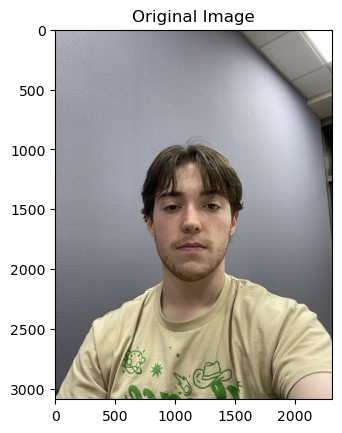

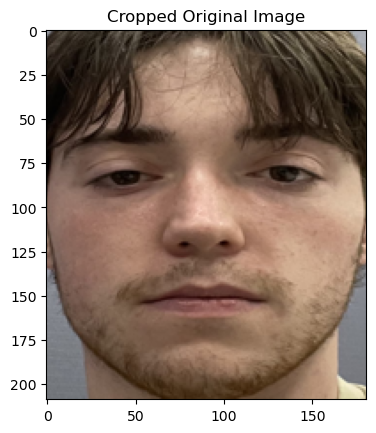

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


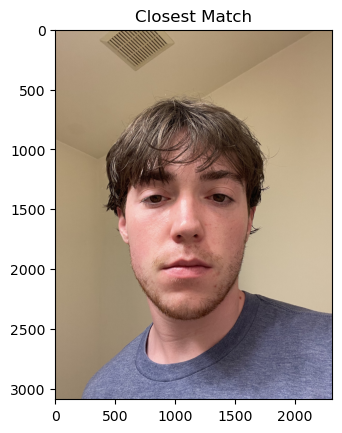

Search Results Indices: [[30]]
Search Results Distances: [[     672.79]]


In [54]:
# Cell 11: Test YOLO Preprocessor and Faiss Closest Match with Sample Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
import faiss
import fiftyone as fo

# Load the YoloPreprocessor, assuming it's already defined in previous cells
#yolo_preprocessor = YoloPreprocessor('best_3.pt')  # Ensure this is the correct path to your YOLO model

# Load the ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet')
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Load the Faiss index from the saved path
index = faiss.read_index('./faiss_indices/my_faiss_index.faiss')  # Adjust path as necessary

# Load the dataset to map sample IDs to filepaths
dataset = fo.load_dataset("MND")
id_to_filepath = {sample.id: sample.filepath for sample in dataset}
sample_ids = list(id_to_filepath.keys())  # ensure you have a list of sample IDs available

def find_closest_match(image_path):
    # Load and display the original image
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.imshow(original_img_rgb)
    plt.title('Original Image')
    plt.show()

    # Process the image using YOLO preprocessor to crop to detected area of interest
    processed_img = preprocess_image(original_img)  # Preprocess the image(original_img)
    plt.imshow(processed_img)
    plt.title('Cropped Original Image')
    plt.show()
    # Convert processed image to the format expected by ResNet50
    pil_img = Image.fromarray(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    resized_img = pil_img.resize((224, 224))
    img_array = keras_image.img_to_array(resized_img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    preprocessed_input = preprocess_input(img_array_expanded_dims)

    # Extract features
    features = feature_model.predict(preprocessed_input).flatten()

    # Search in Faiss index
    query_features = np.array([features]).astype('float32')
    distances, indices = index.search(query_features, 1)  # Search for the closest match

    # Get the sample ID from indices
    closest_sample_id = sample_ids[indices[0][0]]  # Use indices to find sample ID
    closest_image_path = id_to_filepath[closest_sample_id]  # Get the filepath using the sample ID

    # Load and display the closest match
    closest_image = cv2.imread(closest_image_path)
    closest_image_rgb = cv2.cvtColor(closest_image, cv2.COLOR_BGR2RGB)
    plt.imshow(closest_image_rgb)
    plt.title('Closest Match')
    plt.show()

    print("Search Results Indices:", indices)
    print("Search Results Distances:", distances)

# Provide the path to the sample image you want to find a match for
sample_image_path = './testimages/ryan2.jpg'  # Ensure this path is correctly set
find_closest_match(sample_image_path)


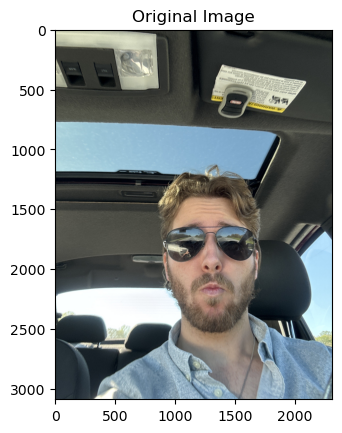

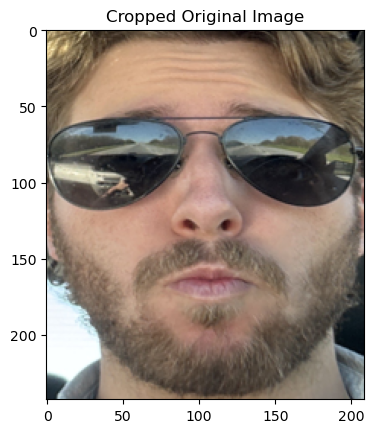

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


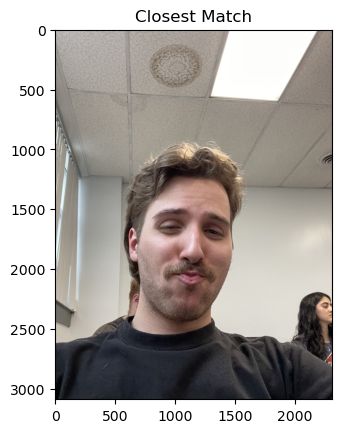

Search Results Indices: [[28]]
Search Results Distances: [[     932.78]]


In [56]:
# Cell 12: Test YOLO Preprocessor and Faiss Closest Match with Sample Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
import faiss
import fiftyone as fo

# Load the YoloPreprocessor, assuming it's already defined in previous cells
#yolo_preprocessor = YoloPreprocessor('best_3.pt')  # Ensure this is the correct path to your YOLO model

# Load the ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet')
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Load the Faiss index from the saved path
index = faiss.read_index('./faiss_indices/my_faiss_index.faiss')  # Adjust path as necessary

# Load the dataset to map sample IDs to filepaths
dataset = fo.load_dataset("MND")
id_to_filepath = {sample.id: sample.filepath for sample in dataset}
sample_ids = list(id_to_filepath.keys())  # ensure you have a list of sample IDs available

def find_closest_match(image_path):
    # Load and display the original image
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.imshow(original_img_rgb)
    plt.title('Original Image')
    plt.show()

    # Process the image using YOLO preprocessor to crop to detected area of interest
    processed_img = preprocess_image(original_img)  # Preprocess the image(original_img)
    plt.imshow(processed_img)
    plt.title('Cropped Original Image')
    plt.show()
    # Convert processed image to the format expected by ResNet50
    pil_img = Image.fromarray(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    resized_img = pil_img.resize((224, 224))
    img_array = keras_image.img_to_array(resized_img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    preprocessed_input = preprocess_input(img_array_expanded_dims)

    # Extract features
    features = feature_model.predict(preprocessed_input).flatten()

    # Search in Faiss index
    query_features = np.array([features]).astype('float32')
    distances, indices = index.search(query_features, 1)  # Search for the closest match

    # Get the sample ID from indices
    closest_sample_id = sample_ids[indices[0][0]]  # Use indices to find sample ID
    closest_image_path = id_to_filepath[closest_sample_id]  # Get the filepath using the sample ID

    # Load and display the closest match
    closest_image = cv2.imread(closest_image_path)
    closest_image_rgb = cv2.cvtColor(closest_image, cv2.COLOR_BGR2RGB)
    plt.imshow(closest_image_rgb)
    plt.title('Closest Match')
    plt.show()

    print("Search Results Indices:", indices)
    print("Search Results Distances:", distances)

# Provide the path to the sample image you want to find a match for
sample_image_path = './testimages/mike2.jpg'  # Ensure this path is correctly set
find_closest_match(sample_image_path)
